# Wind Speed and Wind Energy Production in Ireland

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import numpy as np
from sklearn.linear_model import LinearRegression

Analysis outline:

Weather data:
- Plot of daily wind speed over time
- Plot of monthly wind speed over time

Wind farm data:
- Plot of total capacity per county
- Plot of total capacity over time (in years)
- Forecast of total capacity in 2025
- Plot of capacity per county (can this be plotted on a map with just the county names?)

The wind turbines at Meentycat in Donegal are made by Siemens (https://web.archive.org/web/20060507161509/http://www.airtricity.com/ireland/wind_farms/republic_of_ireland/operating/meentycat/) - if these are the SWT-3.0-108s for example, they have a cut in speed of 3m/s, meaning that's when they start producing power, a rated wind speed of 12m/s, at which point they're operating most efficiently and producing their maximum power, and a cut out wind speed of 25m/s, above which they stop producting power for safety reasons. 

https://en.wind-turbine-models.com/turbines/751-siemens-swt-3.0-108

Between the cut in and rated speeds the power produced varies as wind speed increases:

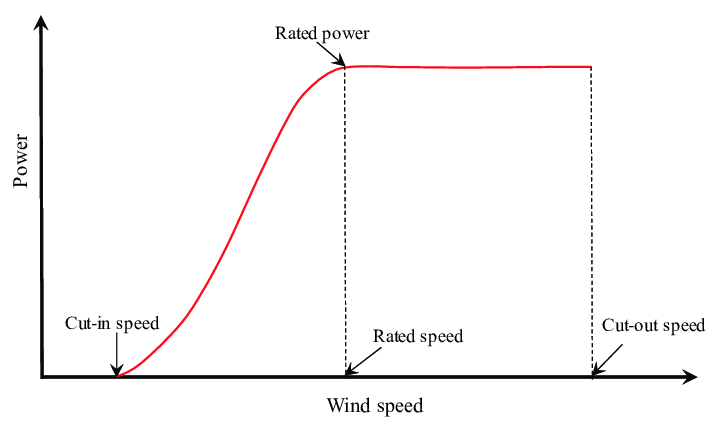

https://www.researchgate.net/post/What-is-the-optimum-wind-speed-to-generate-electricity-by-a-wind-turbine

Question: 
- How often is the average daily wind speed within optimal energy production bounds for the above turbine type?

- Assuming every wind farm has the same types of turbine as Meentycat (and therefore the same wind speed / power profile), how much energy is produced per month compared to the theoretical max capacity of all wind farms?

It may be simpler in this case to ignore the cut in -> rated portion of the power curve, or maybe approximate it linearly, as in 3m/s => 25%, 6m/s => 50% of the rated power, but still <3m/s => 0 power. This is a broad approximation however, the power profile between cut in and rated does not appear to be linear as can be seen above, but this will give an idea of the amount produced. Additionally, not every turbine in the country is the same, and therefore does not have the same power profile, so this is also a broad approximation based on one type of turbine. 

There are additional simplifications in that we must use average wind speed at a maximum granularity of a daily level, rather than hourly reads. We are also unable to resolve wind farms to their most local weather station, so must rely on averages across the country rather than measurements taken in the vicinity of the farm. Finally, we do not know the height above sea level of the wind farms (this is available for the weather stations in both the station details csv and in the headers of the downloaded csv files however). Wind speed changes with height above sea level, typically increasing as elevation increases as shown in the Wind Analysis for Atlantic Marine Energy Test Site report (Loughlin & O'Malley, 2023) - https://www.seai.ie/sites/default/files/publications/Wind-Analysis-for-AMETS-A.pdf 

A large difference in elevation between the turbine and measurement equipment could translate to a large difference in wind speed.

- Plot of approximate energy produced over time

It should also be noted that met eireann encode their wind speeds in knots, so these will have to be converted to m/s.

In [3]:
def knots_to_ms(x):
    kmh = x*1.852
    ms = kmh*(1000/3600)
    return ms

# x in m/s
def power_curve_approx(x):
    # wind speed too low, no power generated
    if x < 3:
        return 0
    # wind speed acceptable but suboptimal, operating at fractional capacity
    if x < 12:
        return x/12
    # wind speed optimal, operating at 100% capacity
    if x < 25:
        return x
    # wind speed too high, turbine disabled
    return 0

In [19]:
wind_data = pd.read_csv('data/wind_data.csv')
wind_data.date = pd.to_datetime(wind_data.date, format='%Y-%m-%d')
wind_farm_data = pd.read_csv('data/wind_farm_data.csv')

/var/folders/s7/bsy4w2n54pvcvlbx9jg9h2040000gn/T/ipykernel_14528/3235794955.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  wind_data = pd.read_csv('data/wind_data.csv')


In [20]:
wind_data

,date,station name,mean_wind_speed,highest_wind_speed,highest_wind_speed_direction,highest_gust,county,name,height(m),latitude,longitude,easting,northing
0,2008-09-19,1775,0.1,0,10,0,Wexford,JOHNSTOWN CASTLE 2,62,52.29778,-6.49667,302631,117200
1,2008-09-20,1775,0.1,0,10,0,Wexford,JOHNSTOWN CASTLE 2,62,52.29778,-6.49667,302631,117200
2,2008-09-21,1775,0.1,0,0,0,Wexford,JOHNSTOWN CASTLE 2,62,52.29778,-6.49667,302631,117200
3,2008-09-22,1775,0.1,0,0,0,Wexford,JOHNSTOWN CASTLE 2,62,52.29778,-6.49667,302631,117200
4,2008-09-23,1775,0.1,0,10,0,Wexford,JOHNSTOWN CASTLE 2,62,52.29778,-6.49667,302631,117200
...,...,...,...,...,...,...,...,...,...,...,...,...,...
83400,2024-12-27,375,5.2,8,190,12,Carlow,OAK PARK,62,52.86111,-6.91528,273000,179500
83401,2024-12-28,375,4.1,8,270,10,Carlow,OAK PARK,62,52.86111,-6.91528,273000,179500
83402,2024-12-29,375,7.5,15,240,22,Carlow,OAK PARK,62,52.86111,-6.91528,273000,179500
83403,2024-12-30,375,9.4,14,200,21,Carlow,OAK PARK,62,52.86111,-6.91528,273000,179500


In [21]:
daily_wind = wind_data[wind_data['date'] > datetime.datetime(2010, 1, 1)].groupby('date')[['mean_wind_speed']].mean().reset_index()

In [22]:
daily_wind

,date,mean_wind_speed
0,2010-01-02,5.471429
1,2010-01-03,6.900000
2,2010-01-04,5.000000
3,2010-01-05,7.342857
4,2010-01-06,8.385714
...,...,...
5473,2024-12-27,4.242857
5474,2024-12-28,4.714286
5475,2024-12-29,8.942857
5476,2024-12-30,12.228571


## Average Wind Speed Trends

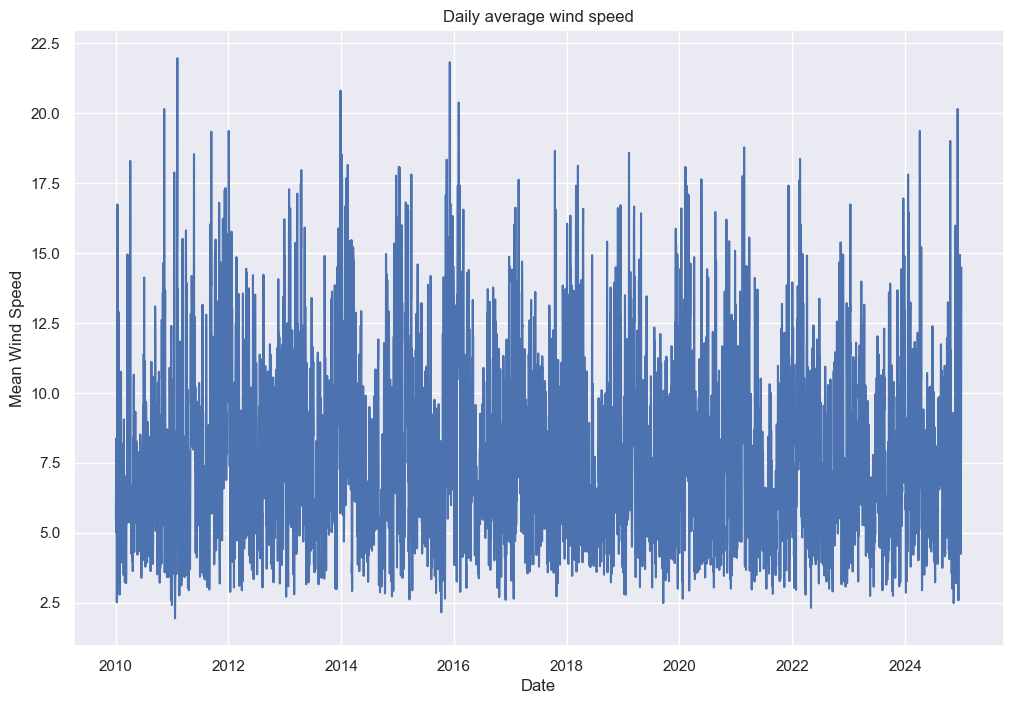

In [23]:
sns.set_theme(style='darkgrid')
plt.figure(figsize=(12,8))
sns.lineplot(data=daily_wind, x='date', y='mean_wind_speed')
plt.title('Daily average wind speed')
plt.xlabel('Date')
plt.ylabel('Mean Wind Speed (knots)')
plt.show()

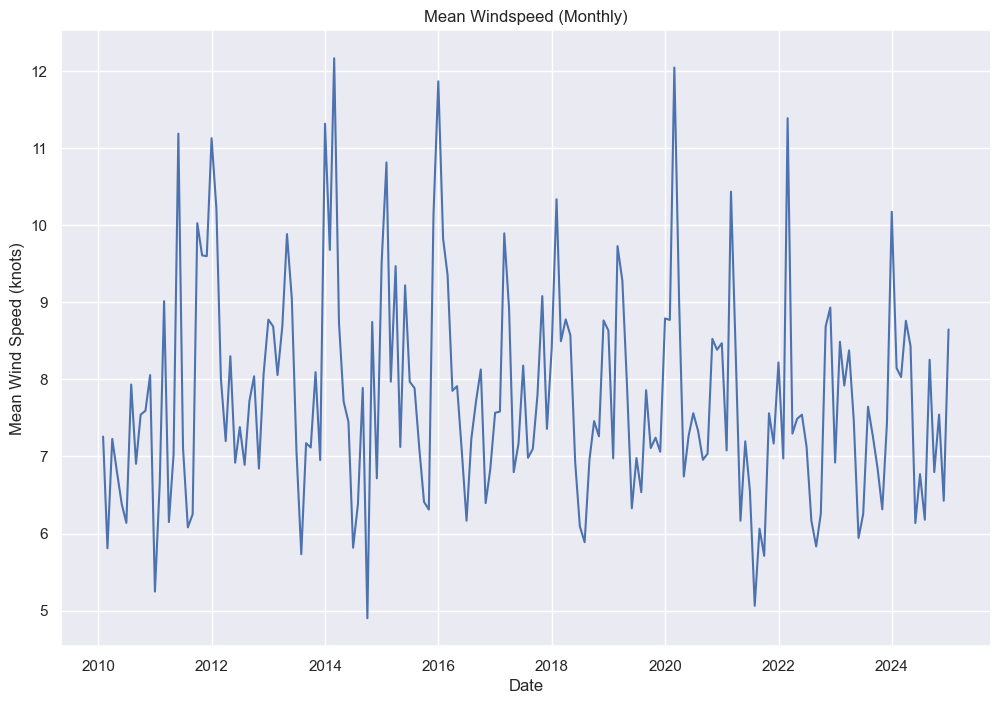

In [25]:
monthly_df = daily_wind.rename(columns={'date':'datetime'})\
    .set_index('datetime')\
    .groupby(pd.Grouper(freq='ME'))[['mean_wind_speed']]\
    .aggregate('mean')\
    .reset_index()\
    .dropna(axis=0, how='any')

sns.set_theme(style='darkgrid')
plt.figure(figsize=(12,8))
sns.lineplot(data=monthly_df, x='datetime', y='mean_wind_speed')
plt.title('Mean Windspeed (Monthly)')
plt.xlabel('Date')
plt.ylabel('Mean Wind Speed (knots)')
plt.show()

In [31]:
wind_farm_data.head()

,Windfarm_Name,DSO_TSO,Connection_Ref,County,Present_Status,Installed_Capacity__MW_,MEC__MW_,Gate,F110kV_Node_Name,Target_Connection,Date_of_Connection,Year_of_Connection,Nat_Grid_E__substation_,Nat_Grid_N__substation_,Type
0,Bellacorrick Wind Farm,DSO,DG955,Mayo,Connected,NaN,6.45,Pre-Gate,Bellacorick,01/10/1992,01/10/1992,1992,98670.0,321420.0,Wind
1,Corrie Mt.,DSO,DG961,Leitrim,Connected,NaN,4.80,Pre-Gate,Arigna,NaN,01/03/1997,1997,190043.0,320081.0,Wind
2,Mount Cronalaght,DSO,DG974,Donegal,Connected,NaN,4.98,Pre-Gate,Letterkenny,01/07/1997,01/07/1997,1997,186118.0,423981.0,Wind
3,Golagh (1),TSO,P25,Donegal,Connected,15.0,15.00,Pre-Gate,Golagh 110 kV,NaN,01/07/1997,1997,203554.0,382308.0,Wind
4,Drumlough Hill Wind Farm,DSO,DG920,Donegal,Connected,NaN,4.80,Pre-Gate,Trillick,01/08/1997,01/08/1997,1997,235797.0,439828.0,Wind


## Wind Farm Energy Capacity

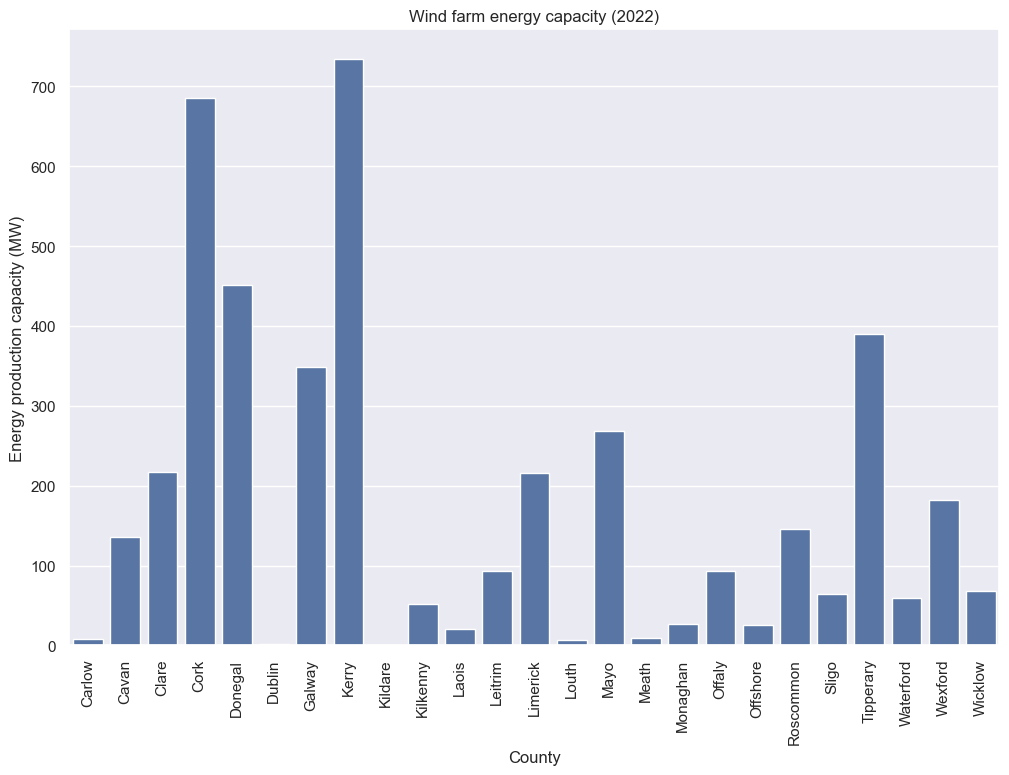

In [71]:
county_capacity = wind_farm_data.groupby('County')[['MEC__MW_']].sum().reset_index()

sns.set_theme(style='darkgrid')
plt.figure(figsize=(12,8))
sns.barplot(data=county_capacity, x='County', y='MEC__MW_')
plt.title('Wind farm energy capacity (2022)')
plt.xlabel('County')
plt.ylabel('Energy production capacity (MW)')
plt.xticks(rotation=90)
plt.show()

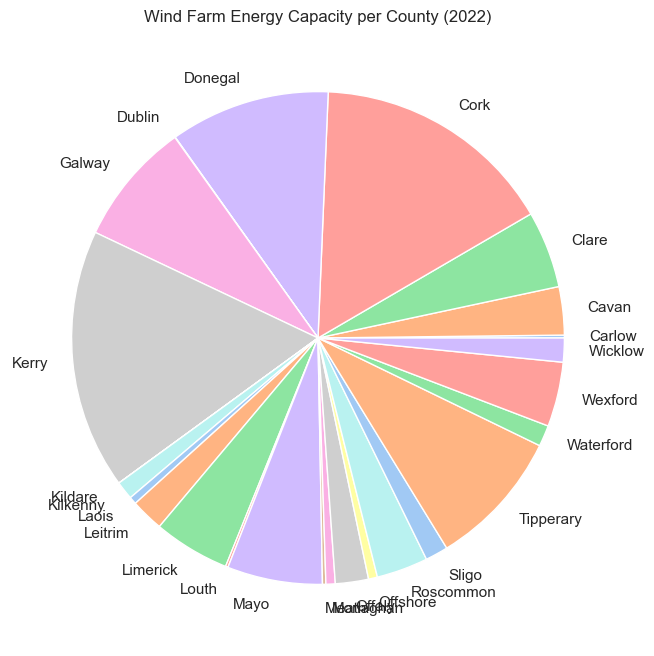

In [76]:

colours = sns.color_palette('pastel')[0:len(county_capacity)]
plt.figure(figsize=(12,8))
plt.pie(county_capacity['MEC__MW_'], labels=county_capacity['County'], colors=colours) 
plt.title("Wind Farm Energy Capacity per County (2022)")
plt.show() 

We can see that Cork, Kerry, Donegal, Galway, and Tipperary have the highest wind energy capacity in the country. This is to be expected, as intuitively we would expect the areas with the highest wind levels to be on the west coast.

In [44]:
yearly_capacity = wind_farm_data.groupby('Year_of_Connection')[['MEC__MW_']].sum().reset_index()

cumulative_capacity = yearly_capacity.set_index('Year_of_Connection').cumsum().reset_index()

We can see that the highest amount of wind energy capacity was added to the grid in 2017, and that capacity was generally being ramped up starting around 2005, however this trend was stalled in 2020, presumably due to disruptions in construction/budget/etc. due to the COVID-19 pandemic.

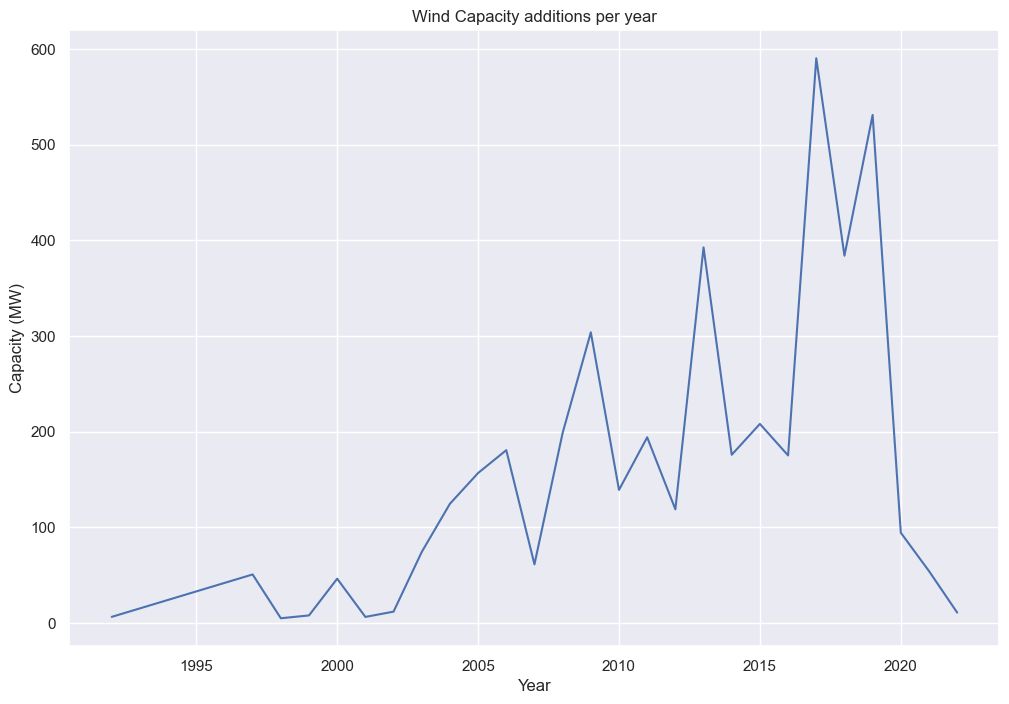

In [41]:
sns.set_theme(style='darkgrid')
plt.figure(figsize=(12,8))
sns.lineplot(data=yearly_capacity, x='Year_of_Connection', y='MEC__MW_')
plt.title('Wind Capacity additions per year')
plt.xlabel('Year')
plt.ylabel('Capacity (MW)')
plt.show()

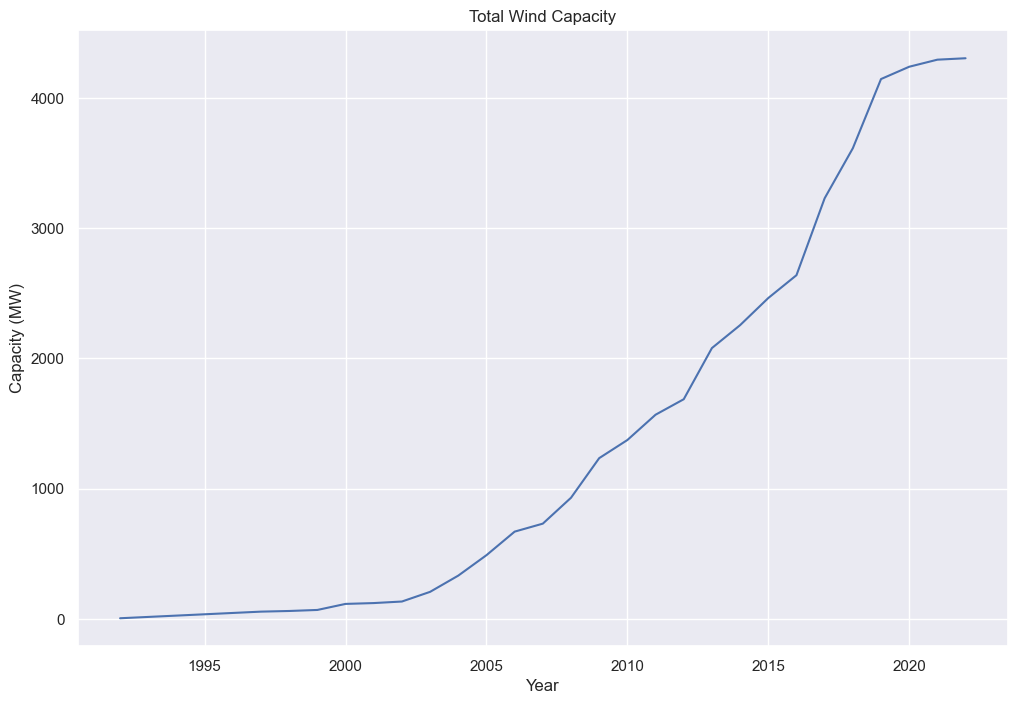

In [45]:
sns.set_theme(style='darkgrid')
plt.figure(figsize=(12,8))
sns.lineplot(data=cumulative_capacity, x='Year_of_Connection', y='MEC__MW_')
plt.title('Total Wind Capacity')
plt.xlabel('Year')
plt.ylabel('Capacity (MW)')
plt.show()

In [46]:
cumulative_capacity[cumulative_capacity['Year_of_Connection'] == 2022]

,Year_of_Connection,MEC__MW_
26,2022,4304.216


In 2022 the maximum energy capacity for all wind farms in Ireland was just over 4.3 GW. Using a linear regression we can predict that this capacity will have increased to just over 4.4GW  in 2025, with the caveat that the above graph does not look particularly linear outside of the timeframe of 2005-2020.

In [51]:
# https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LinearRegression.html
reg = LinearRegression().fit(cumulative_capacity[['Year_of_Connection']], cumulative_capacity[['MEC__MW_']])
reg.predict(np.array([2025]).reshape(-1, 1))

/Users/colleenking/Documents/college/programming_for_data_analytics/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([[4427.60610377]])

In [78]:
# https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LinearRegression.html
filtered_capacity = cumulative_capacity[(cumulative_capacity['Year_of_Connection'] < 2020) & (cumulative_capacity['Year_of_Connection'] >= 2005)]
reg = LinearRegression().fit(filtered_capacity[['Year_of_Connection']], filtered_capacity[['MEC__MW_']])
reg.predict(np.array([2025]).reshape(-1, 1))

/Users/colleenking/Documents/college/programming_for_data_analytics/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([[5121.98782143]])

If the grid capacity trend had continued since 2020 in the same fashion as it had since 2005, a linear model predicts that the total wind farm energy production capacity would be over 5.1GW in 2025.

## Energy Production compared to wind speed

By converting the wind speed in knots to m/s, and then applying the power curve mentioned above, we can see the efficiency of each wind farm in terms of what percentage of their maximum power output woudl the mean wind on a given day have produced.

In [55]:
daily_wind['speed_ms'] = daily_wind['mean_wind_speed'].apply(lambda x: knots_to_ms(x))
daily_wind['wind_energy_pct'] = daily_wind['speed_ms'].apply(lambda x: power_curve_approx(x))
daily_wind.head()

,date,mean_wind_speed,speed_ms,wind_energy_pct
0,2010-01-02,5.471429,2.814746,0.000000
1,2010-01-03,6.900000,3.549667,0.295806
2,2010-01-04,5.000000,2.572222,0.000000
3,2010-01-05,7.342857,3.777492,0.314791
4,2010-01-06,8.385714,4.313984,0.359499


We find that the average daily wind is never at a high enough level to drive our chosen turbine model at 100% output, however, this is the average wind speed across the whole country across the whole day. It is probable that local levels of high wind produce the maximum energy possible for short periods quite often.

In order to improve this model we would ideally have finer granularity of wind speeds both spatially and temporally, and we would like to know the true breakdown of turbine types and associated energy production profiles per wind farm.

In [77]:
daily_wind[daily_wind['wind_energy_pct'] == 1]

,date,mean_wind_speed,speed_ms,wind_energy_pct,year


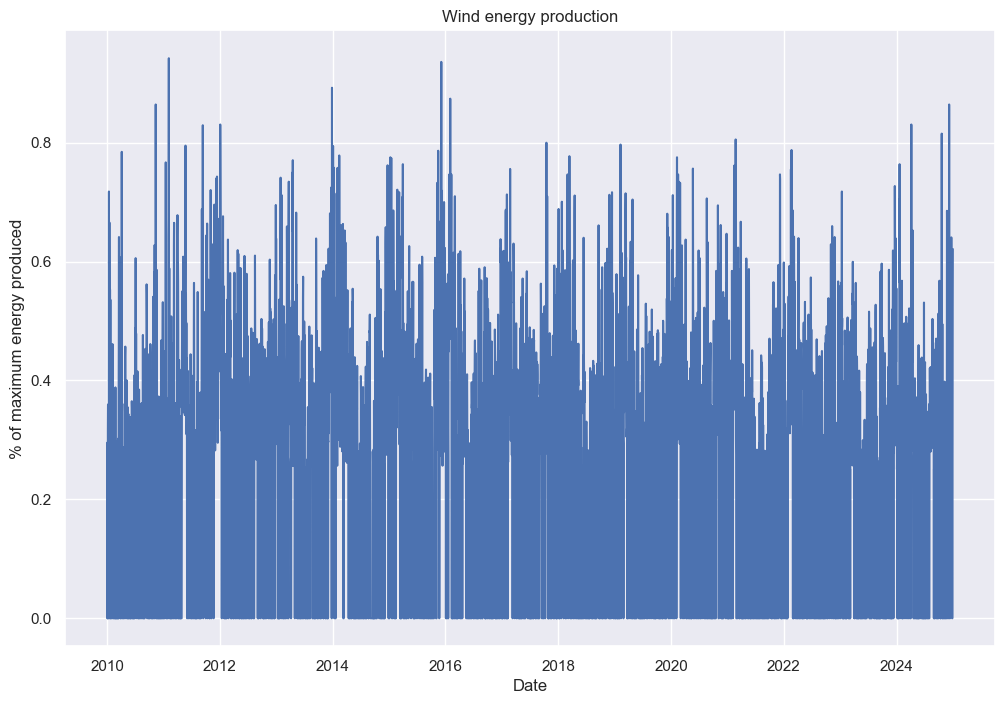

In [57]:
sns.set_theme(style='darkgrid')
plt.figure(figsize=(12,8))
sns.lineplot(data=daily_wind, x='date', y='wind_energy_pct')
plt.title('Wind energy production')
plt.xlabel('Date')
plt.ylabel('% of maximum energy produced')
plt.show()

We can see that depending on the time of year, the average wind speed per day typically drives the turbines to produce between 40-80% of their maximum power output. Winds are stronger inthe winter than the summer, so wind farms operate more efficiently then. 

This will vary throughout the day however, with certain times of particularly strong winds resulting in more efficient operation.

By multiplying this percentage production by the total grid capacity, we can approximate how much energy is produced on a daily basis depending on the average wind speed - this makes the assumption that the grid capacity increases overnight on the 1st of January however in addition to the previously mentioned assumptions around turbine type, locality of wind measurements, etc., so is only an approximation.

We can still see how the energy production has incresed over time as the grid capacity increased, and how production is affected by the seasonal strength of winds.

In [62]:
daily_wind['year'] = daily_wind.date.dt.year
daily_energy_production = cumulative_capacity.rename(columns={'Year_of_Connection': 'year'}).merge(daily_wind, how='inner', on='year')

daily_energy_production['energy'] = daily_energy_production['MEC__MW_']*daily_energy_production['wind_energy_pct']

daily_energy_production.head()

,year,MEC__MW_,date,mean_wind_speed,speed_ms,wind_energy_pct,energy
0,2010,1374.293,2010-01-02,5.471429,2.814746,0.000000,0.000000
1,2010,1374.293,2010-01-03,6.900000,3.549667,0.295806,406.523504
2,2010,1374.293,2010-01-04,5.000000,2.572222,0.000000,0.000000
3,2010,1374.293,2010-01-05,7.342857,3.777492,0.314791,432.615075
4,2010,1374.293,2010-01-06,8.385714,4.313984,0.359499,494.056516


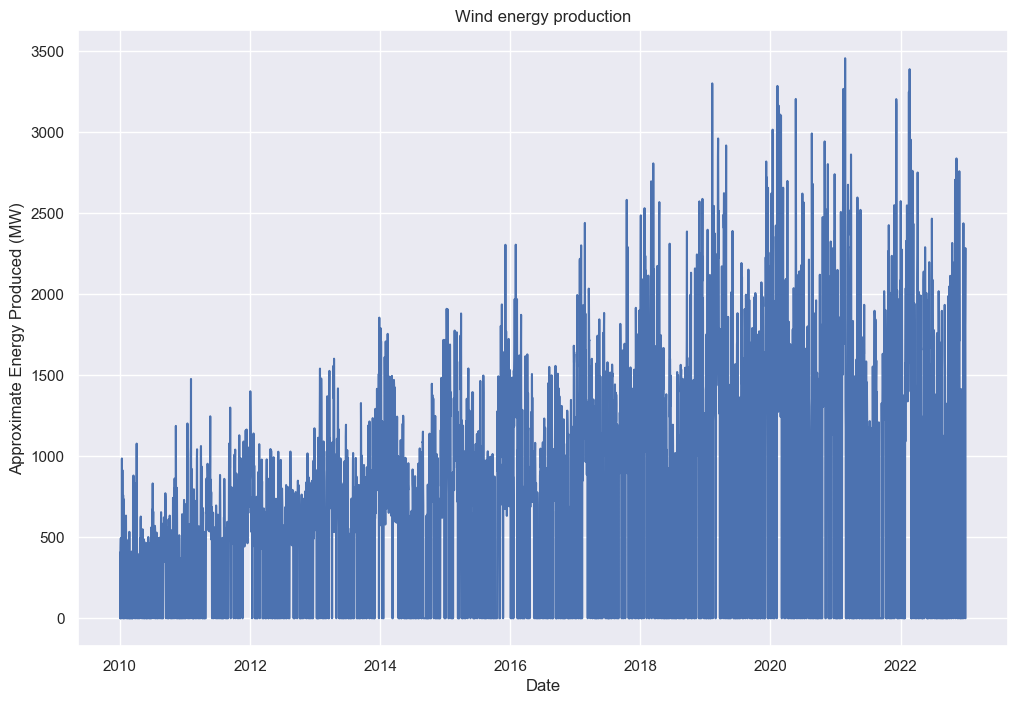

In [65]:
sns.set_theme(style='darkgrid')
plt.figure(figsize=(12,8))
sns.lineplot(data=daily_energy_production, x='date', y='energy')
plt.title('Wind energy production')
plt.xlabel('Date')
plt.ylabel('Approximate Energy Produced (MW)')
plt.show()